# Statistiques descriptives : la compréhension du corpus de questions

Puisque nous disposons des données webscrappées, et avant de passer par une étape de modélisation, il convient de mener une première étude des données, pour comprendre comment se structure le corpus de questions écrites au gouvernement, et de tenter d'identifier quelques premiers résultats pertinents dans l'optique d'une ségrégation par groupe politiques sur le fondement d'une analyse textuelle. 

Après avoir fait les importations nécessaires et créé des fonctions utiles pour la représentation graphique, le présent notebook étudie dans un premier temps la répartition des questions. Nous regardons dans un premier temps la répartition par origine de la question : les groupes politiques, puis en croisant avec une base de donnée scrappée reliant les députés à leur département d'origine, nous étudions aussi la répartition géographique des questions, en considérant le département d'origine du député qui la pose. 

Ensuite, nous nous intéressons au destinataire des questions, en l'espèce un ministère.

Enfin, nous entrons dans l'analyse des questions. Cette étude est menée en deux temps, tout d'abord une analyse purement fréquentielle, avant de se pencher sur des cas particulier moins généralistes mais permettant de se faire une rapide idée de la significativité du corpus. Il s'agit alors de comparer l'utilisation de certains mots suivant son appartenance à des groupes politiques ou sa géographie.

## Préliminaires

Dans cette partie, nous importons les éléments nécessaires (modules, données), définissons des variables récurrentes par la suite (un dictionnaire codant les couleurs des partis politiques pour l'affichage graphique par exemple), avant de définir deux fonctions d'affichage graphique (histogramme et cartographie).

###  Importations des modules et données

Nous procédons ici à l'installation des modules les moins fréquemment utilisés (ceux qui nous ont posé problème à l'usage), puis importons les modules nécessaires pour tout le notebook par soucis de lisibilité, définissons le set de couleurs puis importons les données, à savoir : 
- les données "data_cleaned" : plus de 14k questions au gouvernement, scrappées depuis le site de l'Assemblée Nationale.
- les données "departement_mp" : les députés élus pour chaque département, scrappées depuis Wikipédia


On commence par installer les modules pour la compatibilité :

In [ ]:
!pip install geoviews
!pip install geopandas
!pip install --upgrade pip
!pip install --upgrade Pillow
!pip install wordcloud

On importe ensuite les modules nécessaires pour la suite : 

In [2]:
import os

import matplotlib.pyplot as plt
import pandas as pd

import geoviews
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import Counter

import wordcloud
from wordcloud import WordCloud
import numpy as np
import io
import requests
import PIL
import matplotlib.pyplot as plt

import random

On définit ensuite le set de couleur qui sera utilisé dans les graphes suivants, en particulier pour la lisibilité des groupes politiques : 

In [3]:
dict_couleurs = {
         'NUPES':'red',
         'Ensemble': "yellow",
         'Libertés, Indépendants, Outre-mer et Territoires': 'grey',
         'Les Républicains': 'blue',
         'Démocrate (MoDem et Indépendants)': 'orange',
         'Renaissance': 'yellow',
         'Gauche démocrate et républicaine - NUPES': 'red',
         'La France insoumise - Nouvelle Union Populaire écologique et sociale': 'purple',
         'Rassemblement National': 'black',
         'Horizons et apparentés': 'lightblue',
         'Écologiste - NUPES': 'green',
         'Socialistes et apparentés': 'pink',
         'Non inscrit': 'grey'}

default_color = 'blue' # sera utilisée pour les histogrammes qui ne repésentent par de partis politiques

Importation de la donnée principale de questions écrites au gouvernement, depuis le fichier scrappé nettoyé :

In [4]:
# Aller chercher le chemin absolu du fichier de données pour remplacer le lien lorsque l'on change d'utilisateur
current_dir = os.path.dirname('Statistiques descriptives')  
relative_path = os.path.join('..', 'Datascrapping', 'data_cleaned.csv')
absolute_path = os.path.abspath(os.path.join(current_dir, relative_path))

# Charger le fichier CSV dans un DataFrame 
df_questions = pd.read_csv(absolute_path, encoding='utf-8', sep='|')

# Afficher les dernières lignes du DataFrame
df_questions.tail()


,id,groupe,nom,ministère_interrogé,rubrique,titre,date,question,question_clean
14242,14243,Rassemblement National,Mme Mathilde Paris,Transports,transports ferroviaires,Inégalités dans l'accès aux services ferroviai...,02/01/2024,Mme Mathilde Paris appelle l'attention de M. l...,appeler déléguer auprès transition écologique ...
14243,14244,Socialistes et apparentés,Mme Claudia Rouaux,Mer,transports par eau,Décrets d'application de la loi n°2023-659 du ...,02/01/2024,Mme Claudia Rouaux appelle l'attention de M. l...,appeler secrétaire état auprès charger mer loi...
14244,14245,Gauche démocrate et républicaine - NUPES,M. Yannick Monnet,"Travail, plein emploi et insertion",travail,Lutter contre les accidents du travail par la ...,02/01/2024,M. Yannick Monnet interroge M. le ministre du ...,interroger travail plein emploi insertion néce...
14245,14246,Démocrate (MoDem et Indépendants),M. Pascal Lecamp,"Travail, plein emploi et insertion",travail,Précision des conditions de recours aux contra...,02/01/2024,M. Pascal Lecamp appelle l'attention de M. le ...,appeler travail plein emploi insertion modalit...
14246,14247,Les Républicains,Mme Justine Gruet,Justice,travail,Simplification de la procédure dans la lutte c...,02/01/2024,Mme Justine Gruet appelle l'attention de M. le...,appeler garde sceau justice efficience procédu...


Importation de la liste des députés par département : 

In [5]:
# Aller chercher le chemin absolu du notebook dans lequel se situe la fonction d'import
relative_path = os.path.join('..', 'Datascrapping', 'Scrapping_departements_deputes.ipynb')
absolute_path = os.path.abspath(os.path.join(current_dir, relative_path))

#Importer la fonction
%run -i {absolute_path} --no-import-all

#Stocker le résultat dans un dictionnaire dédié
departement_mp = fonction_depute_par_departement()

### Définition de fonctions de bases pour la représentation graphique 

On définit ici deux fonctions qui seront fréquemment utilisées par la suite : 
- une fonction qui trace un histogramme à partir d'un dictionnaire {clé : valeur unique} en gérant les couleurs suivant les définitions précédentes ;
- une fonction qui dessine une carte des départements à partir d'un dictionnaire {département : valeur unique}

Première fonction : tracé d'histogramme à partir d'un dictionnaire (nous avons fait le choix de pouvoir limiter le nombre de sorties afin de conserver la lisibilité du graphe, c'est le rôle du "n") :

In [6]:
def plot_top_n_keys(dictionary, n, x, y, title): 

    sorted_items = sorted(dictionary.items(), key=lambda x: x[1], reverse=True)
    top_n_items = sorted_items[:n]

    keys, values = zip(*top_n_items)

    # On utilise les couleurs précédentes
    colors = [dict_couleurs.get(cat, default_color) for cat in keys]

    # On crée l'histogramme
    plt.figure(figsize=(10, 6))
    plt.bar(keys, values, color=colors)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Pour la lisibilité
    plt.tight_layout()
    plt.show()

Deuxième fonction : tracé d'une carte avec des valeurs par département à partir d'un dictionnaire (seule la France métropolitaine est affichée) :

In [7]:
def trace_carte(dico_dep,title):
    # On charge une carte des départements, pour afficher la France métropolitaine
    url = "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb" 
    geo = gpd.read_file(url)

    # Fusion du GeoDataFrame avec les valeurs du dictionnaire
    gdf = geo.merge(pd.DataFrame(list(dico_dep.items()), columns=['nom', 'value']), how='left', on='nom')

    # On veut tous les contours des départements, on définit donc une valeur 0 par défaut
    gdf['value'].fillna(0, inplace=True)

    # Affichage de la carte
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.plot(column='value', cmap='GnBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

    plt.title(title)
    plt.axis("off")
    plt.show()

## Partie I : Répartition des questions par leur origine

Pour débuter, nous allons nous intéresser à l'origine des questions au gouvernement, en les comptant par groupes ou en les regroupant géographiquement.




### Répartition par groupe politique d'origine

Le résultat est facile à obtenir avec les fonctions précédentes : on compte simplement le nombre de questions par groupe.

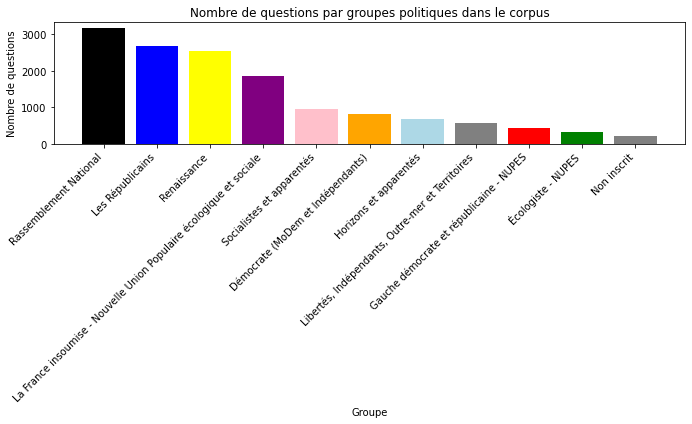

In [8]:
# On génère le dictionnaire {groupe : nb de questions}
groupes = Counter(df_questions['groupe'].tolist()) 

# On le représente graphiquement
plot_top_n_keys(groupes, 30, x="Groupe", y="Nombre de questions", title= f'Nombre de questions par groupes politiques dans le corpus')

On remarque assez logiquement que les groupes les plus présents à l'Assemblée sont à l'origine du plus grand nombre de questions. Cependant, par soucis de lisibilité, il pourrait être utile de grouper les membres de l'intergroupe Nouvelle Union Populaire Ecologique et Sociale (NUPES), ainsi que l'union de la majorité présidentielle Renaissance - Horizon - Modem, "Ensemble pour la majorité présidentielle", abrégée "Ensemble":

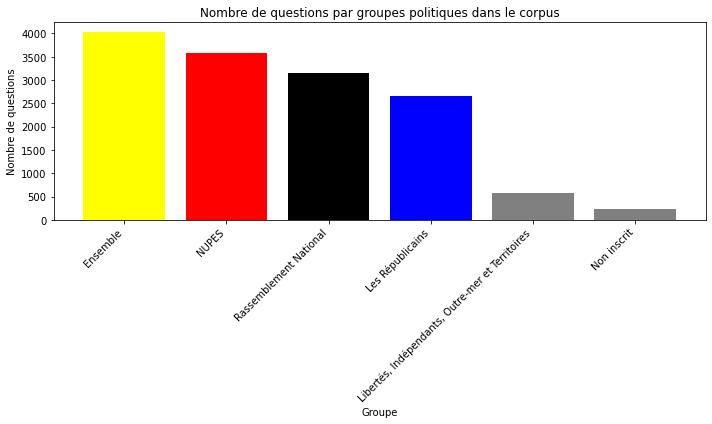

In [9]:
#Création d'un dictionnaire d'union de la gauche via l'intergroupe NUPES
keys_to_sum = ['Gauche démocrate et républicaine - NUPES', 'La France insoumise - Nouvelle Union Populaire écologique et sociale', 'Écologiste - NUPES','Socialistes et apparentés']

total_sum = sum(groupes[key] for key in keys_to_sum)

for key in keys_to_sum:
    del groupes[key]

groupes['NUPES'] = total_sum

#Idem pour la majorité
keys_to_sum = ['Renaissance', 'Démocrate (MoDem et Indépendants)', 'Horizons et apparentés']

total_sum = sum(groupes[key] for key in keys_to_sum)

for key in keys_to_sum:
    del groupes[key]

groupes['Ensemble'] = total_sum

#Affichage du résultat
plot_top_n_keys(groupes, 30, x="Groupe", y="Nombre de questions", title= f'Nombre de questions par groupes politiques dans le corpus')

Une remarque vient naturellement : le nombre de questions suit le nombre de députés dans chaque groupe. Or la réponse relative nous intéresse plus que la réponse absolue, c'est à dire que nous voulons savoir qui pose le plus de questions par député. Il suffit alors de diviser le nombre de questions par le nombre de députés :

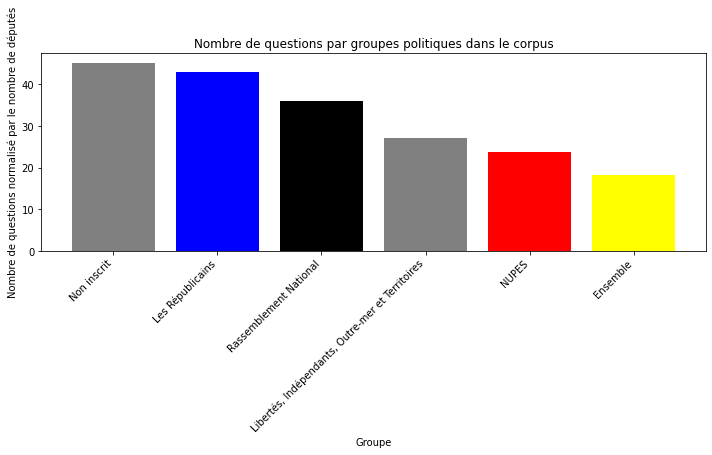

In [10]:
# Dictionnaire avec le nombre de députés dans chaque groupes 
dico_nb_par_groupe = {'Ensemble' :220, 
                      "NUPES": 151,
                      "Rassemblement National": 88,
                      "Les Républicains": 62,
                      "Libertés, Indépendants, Outre-mer et Territoires" : 21,
                      "Non inscrit": 5
                    }

# On divise 
groupes_normalise = Counter({key : groupes[key] / dico_nb_par_groupe[key] for key in dico_nb_par_groupe})


# On affiche le résultat
plot_top_n_keys(groupes_normalise, 30, x="Groupe", y="Nombre de questions normalisé par le nombre de députés", title= f'Nombre de questions par groupes politiques dans le corpus')

Le résultat change alors du tout au tout ! On remarque que la majorité présidentielle se place très loin derrière les autres groupes en termes de questions écrites au gouvernement (ce qui n'est pas illogique puisqu'elle est la majorité dudit gouvernement, et donc en particulier que les ministres en sont issus). 

Le premier barplot est plus suprenant et moins facile à interpréter, il s'agit d'un cas de bord (5 députés), il n'est pas très intéressant. 

On remarque ensuite la place des oppositions, qui semblent en particulier à droite, affectionner le recours aux questions écrites. 

### Répartition par département d'origine

On peut ensuite s'intéresser à l'origine géographique du député posant les questions, pour distinguer par exemple des départements urbains de départements ruraux.

In [11]:
# On compte d'abord les questions par députés
liste_deputes = df_questions['nom'].tolist()

liste_meme_format = [entry.replace('M. ', '').replace('Mme ', '') for entry in liste_deputes]

mp_numbers = Counter(liste_meme_format)

In [12]:
# On agrège par départements
departement_sums = {}

for departement, mp_list in departement_mp.items():
    sum_for_departement = sum(mp_numbers.get(mp, 0) for mp in mp_list)
    departement_sums[departement] = sum_for_departement


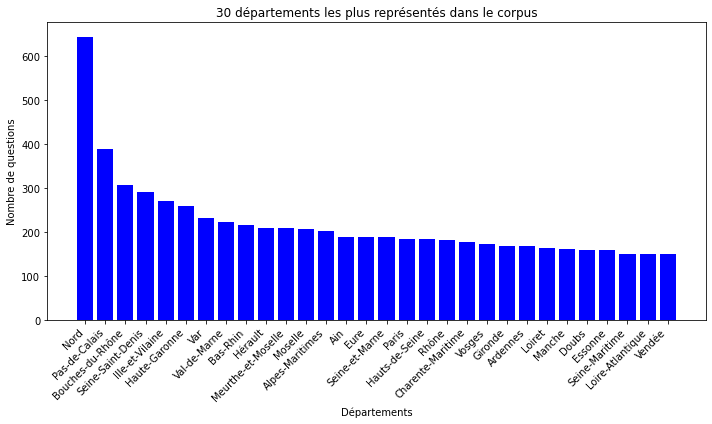

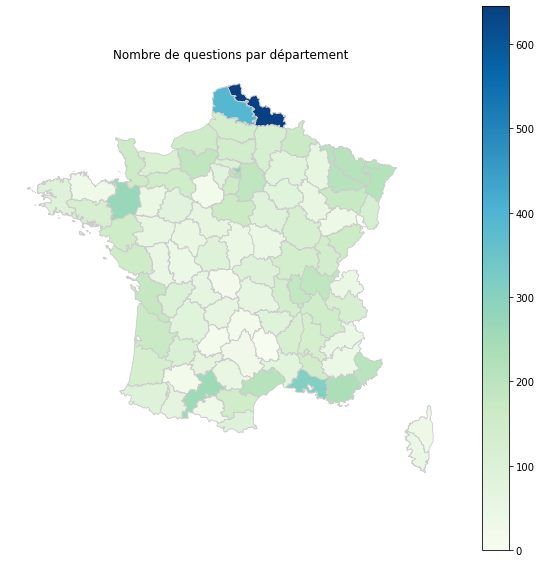

In [13]:
# On affiche les résultats sous forme d'histogramme et de carte
n=30
plot_top_n_keys(departement_sums, n, x="Départements", y="Nombre de questions", title= f'{n} départements les plus représentés dans le corpus')
trace_carte(departement_sums,f"Nombre de questions par département")

In [14]:
values = np.array(list(departement_sums.values()))
median = np.median(values)
median

93.0

La répartition est assez surprenante, avec un département sortant significativement de la distribution. La médiane est à 93 questions, ce qui n'est pas aberrant. On peut regarder le nombre de députés par département pour voir si cela constitue une explication :

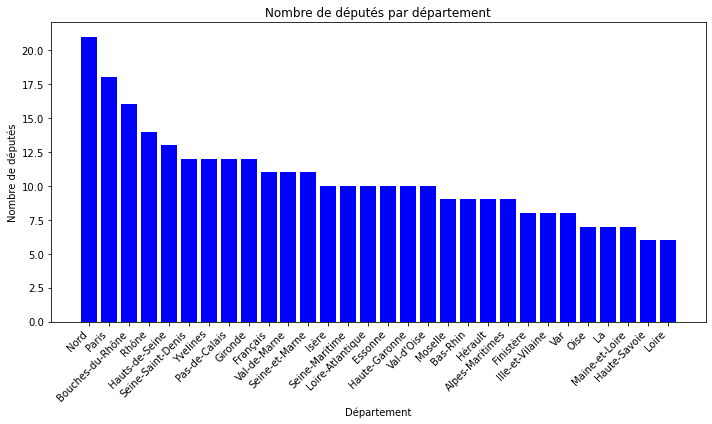

In [15]:
count_mp = {key: len(values) for key, values in departement_mp.items()}
plot_top_n_keys(count_mp, 30, x="Département", y="Nombre de députés", title= f'Nombre de députés par département')

On effectue donc la division pour avoir des résultats plus cohérents :

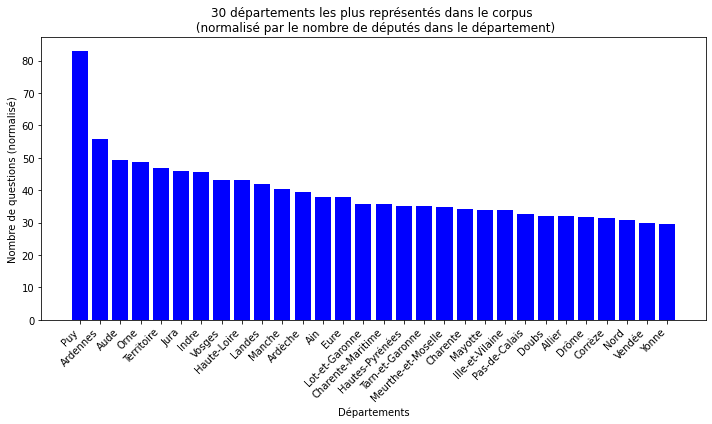

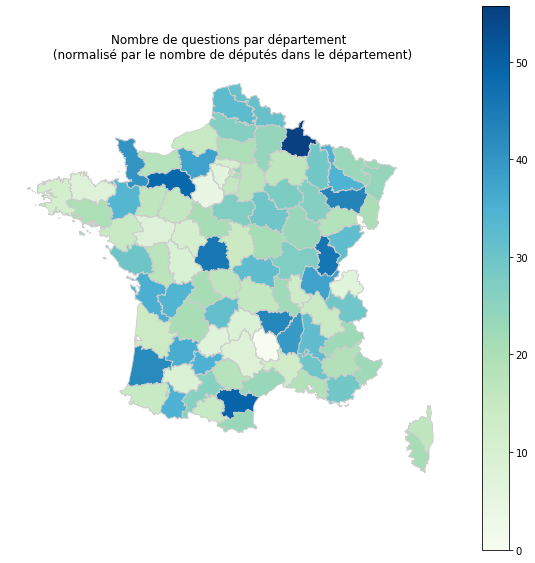

In [16]:
# On divise 
dep_normalise = Counter({key : departement_sums[key] / count_mp[key] for key in count_mp})

# On affiche les résultats sous forme d'histogramme et de carte
n=30
plot_top_n_keys(dep_normalise, n, x="Départements", y="Nombre de questions (normalisé)", title= f'{n} départements les plus représentés dans le corpus \n (normalisé par le nombre de députés dans le département)')
trace_carte(dep_normalise,f"Nombre de questions par département \n (normalisé par le nombre de députés dans le département)")

La répartition représente assez largement - c'est une surprise - des départements peu peuplés (Ardennes, Puy de Dôme, Ardèche...). Les questions écrites pourrait donc être un moyen d'attirer l'attention du gouvernement sur des problématiques locales.

Les questions au gouvernement semblent ainsi un moyen de représenter équitablement les territoires, sans surreprésenter les métropoles ou grandes agglomérations.

## Partie II : Répartition des question par thématique : rubrique et ministère

On s'intéresse ici à l'objet des question (rubrique), et à leur destinataire (ministère auquel la question est adressée). L'enjeu est de déterminer si certains thèmes sont particulièrement ciblés en comparant les deux.

### Répartition par ministère

On utilise les codes précedents pour afficher les 30 ministères les plus questionnés :

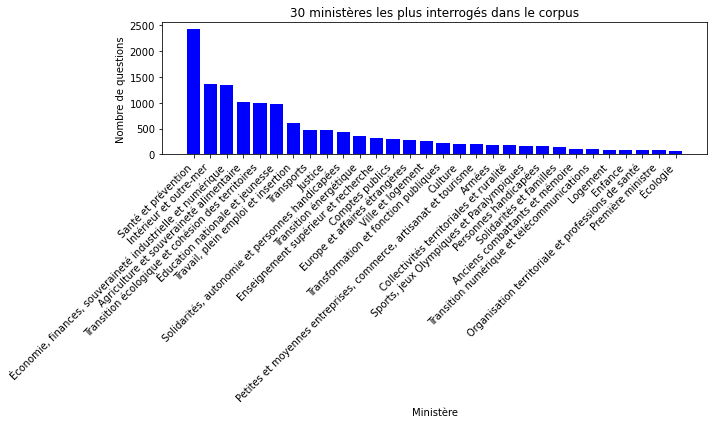

In [17]:
ministere = Counter(df_questions['ministère_interrogé'].tolist())
n=30
plot_top_n_keys(ministere, n, x="Ministère", y="Nombre de questions", title= f'{n} ministères les plus interrogés dans le corpus')

Quelques ministères se distinguent assez naturellement : Santé, Intérieur et Economie, suivis par l'Agriculture, l'Ecologie et l'Education. Rien ici de très suprenant, car ces ministères régaliens sont souvent des ministères qui recouvrent de nombreux portefeuilles d'attributions. On note plutôt en creux la place suprenante de la Justice, des Armées et des Affaires étrangères, qui se situent loin derrière les autres ministères de premier plan. 

Les questions au gouvernement semblent donc un moyen d'interpeler en priorité sur des affaires intérieures. 

### Répartition par rubrique

Comme précédemment, on affiche l'histogramme des 30 rubriques les plus présentes : 

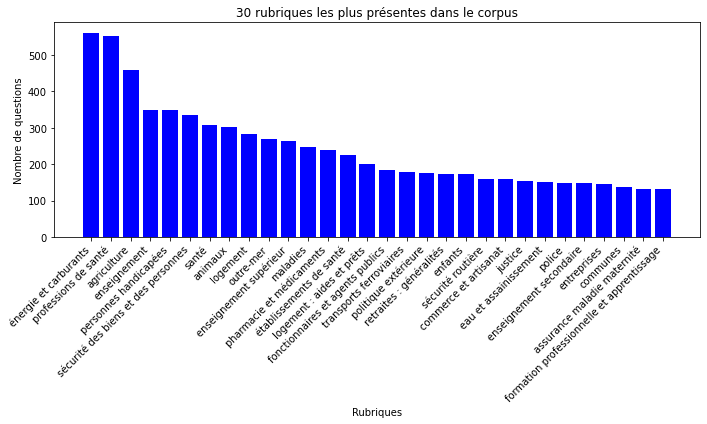

In [18]:
rubrique = Counter(df_questions['rubrique'].tolist())
n=30
plot_top_n_keys(rubrique, n, x="Rubriques", y="Nombre de questions", title= f'{n} rubriques les plus présentes dans le corpus')

On constate la cohérence des rubriques avec les ministères évoqués précédemment : les thématiques de santé et d'économie reviennent au premier plan, aux côtés de thématiques couvertes par Beauvau. Ce niveau de granularité permet cependant de raccrocher la politique extérieure et la justice, écrasés par le graphe précédent. 

L'analyse précédente semble tenir, ce graphe ajoutant une dimension de diversité importante des thématiques traitées. 

On peut donc conclure prudemment sur l'usage des questions écrites au gouvernement, comme étant des outils d'interpellation du gouvernement sur des thématiques variées, en particulier sur les affaires intérieures en lien avec les préoccupations des français (économie et santé). 

## Partie III : Etudes du contenu par analyse fréquentiste


Après avoir regardé dans le détail les problématiques de répartition des questions, nous pouvons nous intéresser au contenu même des questions. 

On utilisera pour cela la colonne dédiée du dataframe ("question_clean"), pour commencer par une analyse fréquentiste d'apparition des mots.

Après un histogrammme donnant un résultat lisible, le nuage de mot fournira un résultat plus graphique.

In [19]:
# On commence par grouper la colonne en un unique str
questions = " ".join(df_questions["question_clean"])


In [20]:
# On compte les occurrences
occurrences = WordCloud().process_text(questions)

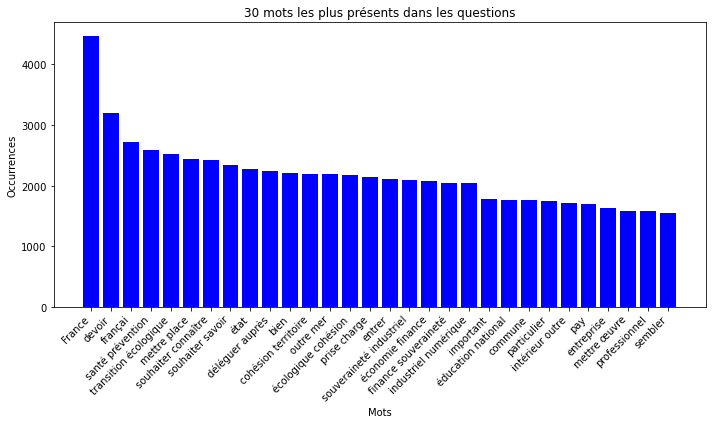

In [21]:
# On les affiche

n=30
plot_top_n_keys(occurrences, n, x="Mots", y="Occurrences", title= f'{n} mots les plus présents dans les questions')

(-0.5, 959.5, 865.5, -0.5)

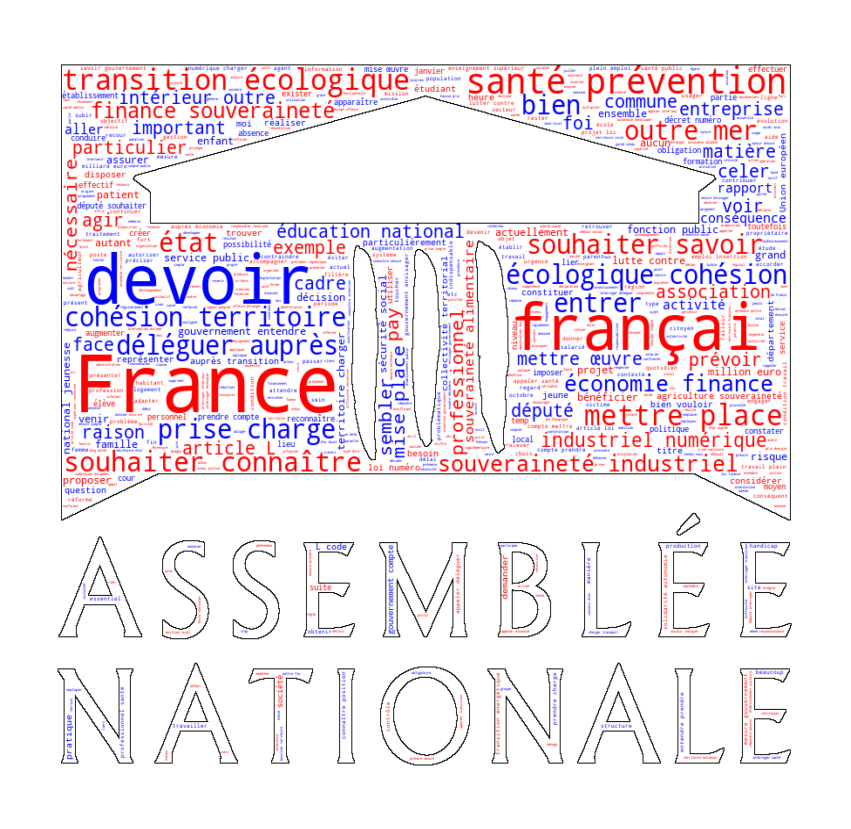

In [22]:

# Aller chercher le chemin absolu de l'image
relative_path = os.path.join('..', 'Statistiques descriptives', 'an_logo.png')
absolute_path = os.path.abspath(os.path.join(current_dir, relative_path))
img = absolute_path

# Création du masque
an_mask = np.array(PIL.Image.open(img))

# Création du nuage de mots
wc = wordcloud.WordCloud(background_color="white", max_words=200000, mask=an_mask, contour_width=0.1, contour_color='black').generate(questions)

def couleur(word, font_size, position, orientation, random_state=None, **kwargs):
    # Randomly choose between red and blue
    color = random.choice(['red', 'blue'])
    return color

plt.figure(figsize=(15, 15))
plt.imshow(wc.recolor(color_func=couleur), interpolation='bilinear', aspect='auto')
plt.axis("off")

Les résultats sont plutôt décevants : la plupart des mots ne sont pas très significatifs, soit lorsqu'ils sont simplement des verbes classiquement usités dans les tournures formelles de questions écrites, soit lorsqu'ils reprennent les noms de ministères.

On remarque également des étrangetés, probablement dûes à la lemmatization, qui semble avoir tronqué des mots, et rend le tout moins explicite.

Le bilan est donc en demi-teinte pour cette analyse fréquentiste, qui ne révèle pas grand chose de nouveau sur le corpus de questions. Une analyse plus fine passant par la modélisation permettrait peut-être d'en faire dire plus au corpus. 

Une autre approche naïve pourrait donc consister en une étude spécifique pour quelques mots particulièrement significatifs. La partie suivante tente de la mettre en place de manière automatisée. 

## Partie IV : Etudes de quelques mots discriminants... qui prononce quoi, et où ? 

Cette partie tente d'analyser quelques mots significatifs pour regarder si leur origine permet de ségreger les groupes politiques.

La première observation que l'on peut faire est que certains mots apparaissent fréquemment, et qu'ils pourraient être connotés politiquement. 

Le simple comptage n'apprend pas grand chose, c'est l'approche fréquentiste précédente. On peut donc essayer de regarder quels groupes mentionnent le mot dans le plus grand nombre de questions :

In [23]:
# Automatisation de l'approche : on crée une fonction qui systématise l'étude pour une liste de target_words
def qui_prononce_quoi(target_words):
    filtered_rows = df_questions[df_questions['question_clean'].str.contains('|'.join(target_words))]
    selection_lignes = filtered_rows['groupe'].tolist()
    dico_prononce = Counter(selection_lignes)

    # On adapte le titre 
    if len(target_words) == 1:
        title = f"Utilisation du mot {target_words[0]} par groupe politique"
    else:
        title = f"Utilisation des mots \n {', '.join(target_words[:-1])} et {target_words[-1]} par groupe politique"

    # On affiche
    plot_top_n_keys(dico_prononce, n=30, x="Groupe", y="Occurrences", title = title)

On l'applique ensuite au premier exemple : 

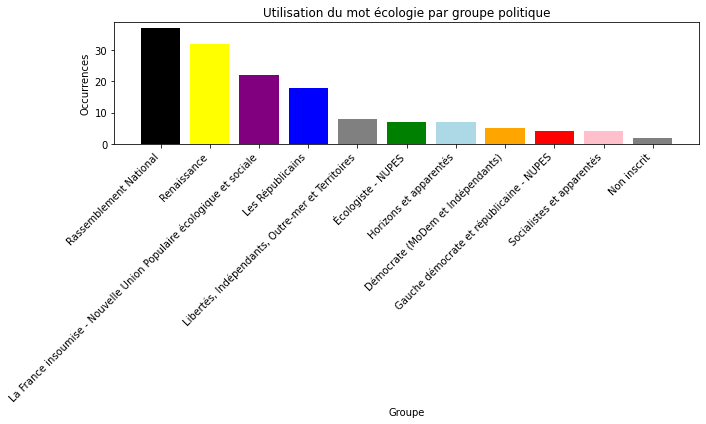

In [24]:
qui_prononce_quoi(['écologie'])

On observe que le RN arrive en tête de l'utilisation du mot "écologie", ce qui paraît surprenant, car ce n'est pas a priori leur thème de prédilection. Or on se souvient que le RN était très représenté dans le corpus de questions. On peut donc essayer de normaliser le nombre d'occurrences du mot par le nombre de questions. 

Il suffit d'adapter la question précédente : 

In [25]:
def qui_prononce_quoi_normalise(target_words):
    filtered_rows = df_questions[df_questions['question_clean'].str.contains('|'.join(target_words))]
    selection_lignes = filtered_rows['groupe'].tolist()
    dico_prononce = Counter(selection_lignes)
    questions_par_groupe = Counter(df_questions['groupe'].tolist())

    # On divise ici pour normaliser
    dico_prononce_normalise = Counter({key : dico_prononce[key] / questions_par_groupe[key] for key in questions_par_groupe})

    #On adapte le titre
    if len(target_words) == 1:
        title = f"Utilisation du mot {target_words[0]} par groupe politique (normalisé)"
    else:
        title = f"Utilisation des mots \n {', '.join(target_words[:-1])} et {target_words[-1]} par groupe politique \n (normalisé)"


    plot_top_n_keys(dico_prononce_normalise, n=30, x="Groupe", y="Occurrences normalisées par le nombre de questions du groupe", title = title)

Et on peut l'appliquer à l'exemple précédent :

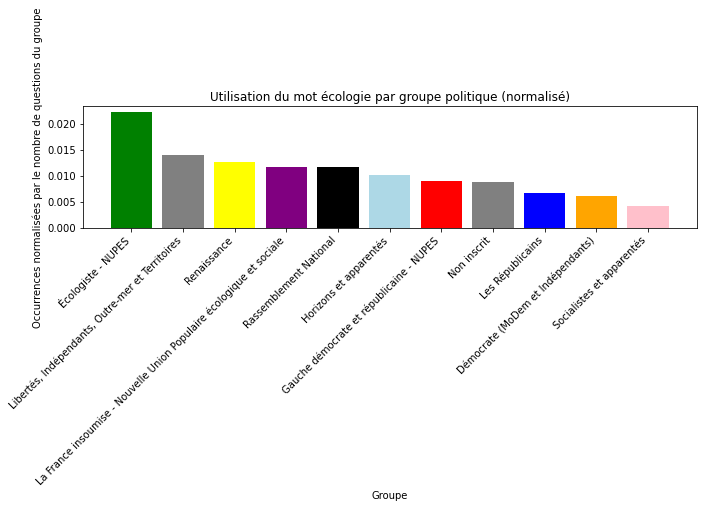

In [26]:
qui_prononce_quoi_normalise(['écologie'])

Le résultat est rassurant : le parti écologiste fait de l'écologie son thème de prédilection, et on le retrouve dans l'approche normalisée de répartition du nombre d'utilisations du mot. 

La surreprésentation du RN dans le premier résultat était clairement dûe à leur surreprésentation dans le nombre de questions du corpus, cela confirme également la pertinence d'une approche normalisée pour l'obtention de résultats interprétables. 

On peut ensuite changer le type de représentation, pour avoir un résultat plus graphique, par exemple sous la forme d'un diagramme circulaire. Il s'agit simplement d'adapter le code précédent sous cette forme : 

In [27]:
def qui_prononce_quoi_camembert(target_words):
    filtered_rows = df_questions[df_questions['question_clean'].str.contains('|'.join(target_words))]
    selection_lignes = filtered_rows['groupe'].tolist()
    dico_prononce = Counter(selection_lignes)

    dico_prononce = Counter(selection_lignes)
    questions_par_groupe = Counter(df_questions['groupe'].tolist())
    nb_questions = len(df_questions['groupe'].tolist())

    dico_prononce_normalise = Counter({key : dico_prononce[key] / questions_par_groupe[key] for key in questions_par_groupe})

    #pour avoir un affichage plus comode en enlevant les catégories non significatives
    dico_prononce_normalise_filtre = {cat: val for cat, val in dico_prononce_normalise.items() if val >= 1/nb_questions}

    categories = list(dico_prononce_normalise_filtre.keys())
    values = list(dico_prononce_normalise_filtre.values())

    colors = [dict_couleurs.get(cat, 'blue') for cat in categories]

    # Création du diagramme circulaire
    plt.figure(figsize=(8, 8))
    plt.axes(aspect='equal')  

    plt.pie(values, labels=categories, autopct='%1.1f%%', startangle=90, colors=colors)

    #White center pour la lisibilité
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    #On adapte le titre
    if len(target_words) == 1:
        title = f"Diagramme circulaire de l'usage du mot {target_words[0]} par les groupes politiques"
    else:
        title = f"Diagramme circulaire de l'usage des mots \n {', '.join(target_words[:-1])} et {target_words[-1]} par les groupes politiques"


    plt.title(title)

    plt.show()

On peut l'appliquer à plusieurs exemples, en l'évaluant sur des champs lexicaux particuliers :

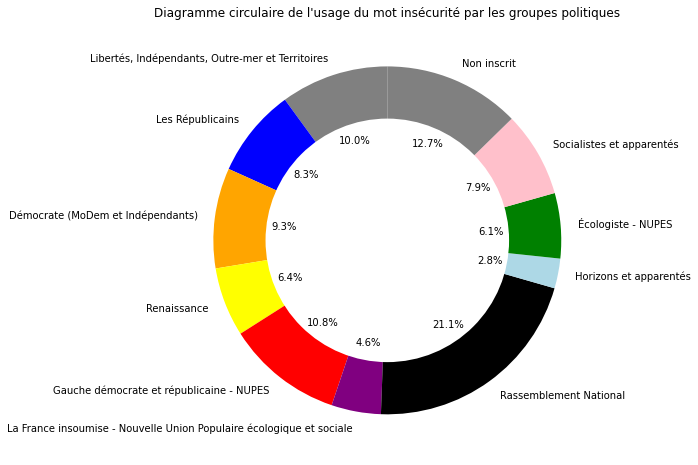

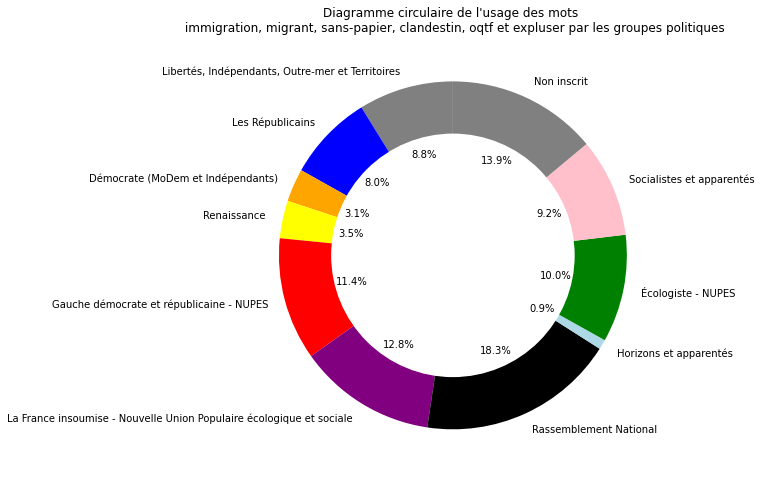

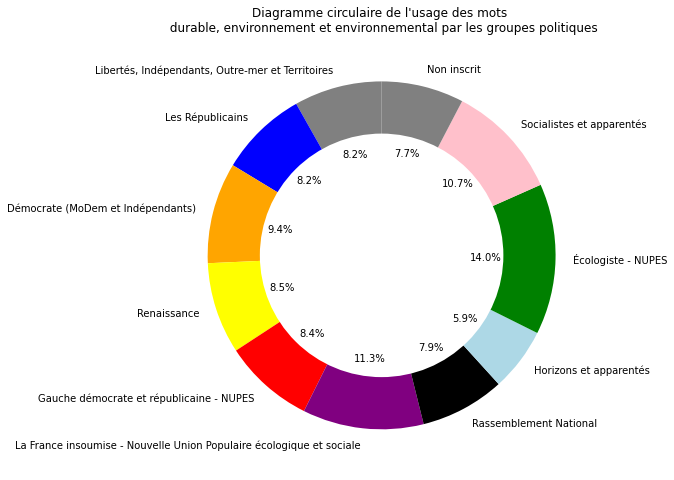

In [28]:
qui_prononce_quoi_camembert(['insécurité'])
qui_prononce_quoi_camembert(['immigration','migrant','sans-papier','clandestin','oqtf','expluser'])
qui_prononce_quoi_camembert(['durable','environnement','environnemental'])

On observe ici que le type de représentation influence grandement notre perception : le diagramme circulaire tend à rendre les résulats plus similaires, tandis que l'histogramme est plus objectif. 

Sur les mots testés, les résultats sont plutôt probants. Le parti ciblé par le champ lexical arrive naturellement premier, mais il ne se distingue pas nécessairement très largement. 

Après cette approche par groupes politiques, on peut aussi regarder de quel département sont élus les députés qui prononcent les mots que nous ciblons. On effectue le même travail qu'en partie I, en ajoutant simplement un filtre pour ne garder que les questions qui contiennent les mots ciblés.

In [29]:
def localisation_mot(target_words):

    #on récupère la somme des questions par département (incluant ce mot)
    filtered_rows = df_questions[df_questions['question_clean'].str.contains('|'.join(target_words))]
    selection_deputes = filtered_rows['nom'].tolist()
    liste_meme_format = [entry.replace('M. ', '').replace('Mme ', '') for entry in selection_deputes]

    mp_numbers = Counter(liste_meme_format)

    departement_partial_sums = {}

    for departement, mp_list in departement_mp.items():
        sum_for_departement = sum(mp_numbers.get(mp, 0) for mp in mp_list)
        departement_partial_sums[departement] = sum_for_departement

    #on récupère la somme des questions par département pour avoir des facteurs de normalisation

    departement_sums = {}

    deputes = df_questions['nom'].tolist()
    liste_meme_format = [entry.replace('M. ', '').replace('Mme ', '') for entry in deputes]

    all_mp_numbers = Counter(liste_meme_format)

    for departement, mp_list in departement_mp.items():
        sum_for_departement = sum(all_mp_numbers.get(mp, 0) for mp in mp_list)
        departement_sums[departement] = sum_for_departement


    #on normalise le premier dictionnaire par le second
    dico_normalise = Counter({key: departement_partial_sums[key] / departement_sums[key] if departement_sums[key] != 0 else 0 for key in departement_sums})
    
    #On adapte le titre
    if len(target_words) == 1:
        title = f"D'où sont issus les députés qui prononcent le mot {target_words[0]} ?"
    else:
        title = f"D'où sont issus les députés qui prononcent les mots \n {', '.join(target_words[:-1])} et {target_words[-1]} ?"


    plot_top_n_keys(dico_normalise, n=30, x="Département", y="Occurrences", title = title)
    trace_carte(dico_normalise,title)

On peut tenter cette approche sur un premier exemple :

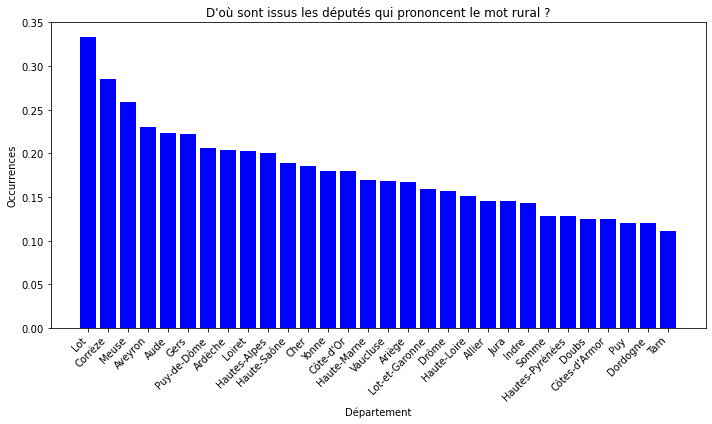

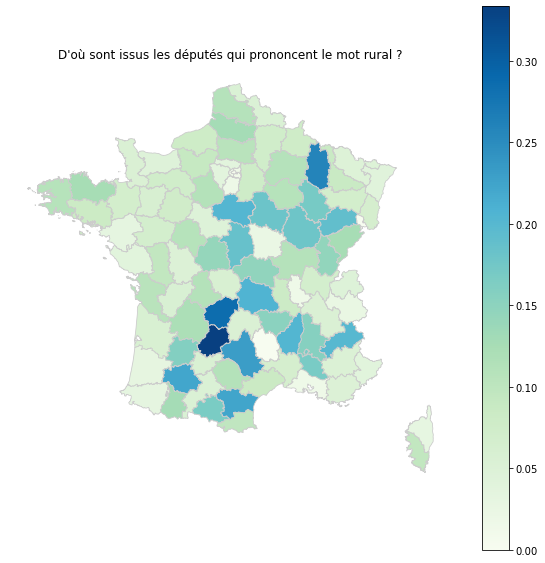

In [30]:
target_words = ["rural"]

localisation_mot(target_words)

On voit assez clairement se dessiner ici la "diagonale du vide", ce qui semble cohérent avec la thématique.

Un second exemple du même type donne également de bons résultats :

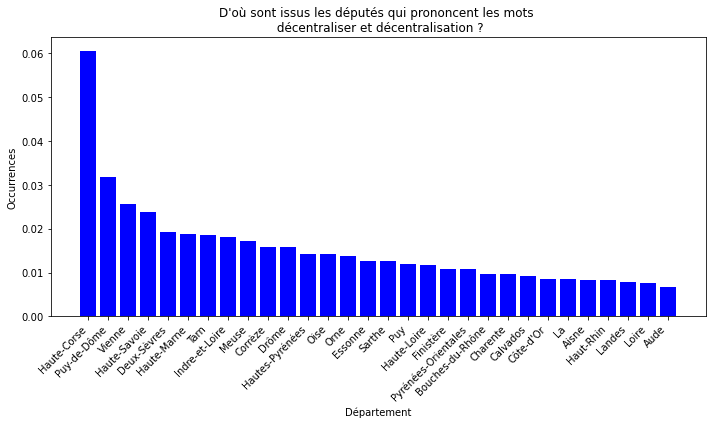

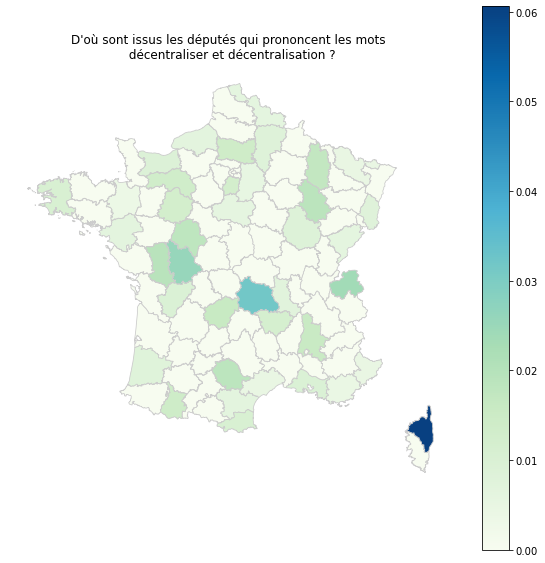

In [31]:
target_words = ["décentraliser","décentralisation"]

localisation_mot(target_words)

Cette approche semble satisfaisante sur les mots testés, cependant elle ne s'applique pas nécessairement à tous les mots. Les questions de ruralité et décentralisation se prêtent particulièrement à une analyse géographique, pour autant, une problématique de développement durable est mieux répartie sur le territoire, et donne donc des résultats moins probants, en témoigne l'exemple suivant.

NB : Sur un champs lexical lié aux problématiques d'immigration clantestine, le corpus met particulièrement en valeur les départements d'outre-mer, ce qui est assez cohérent mais pas très graphique sur une carte métropolitaine.

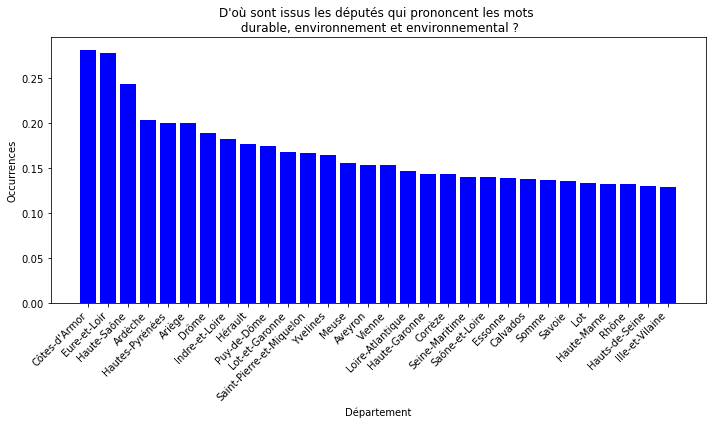

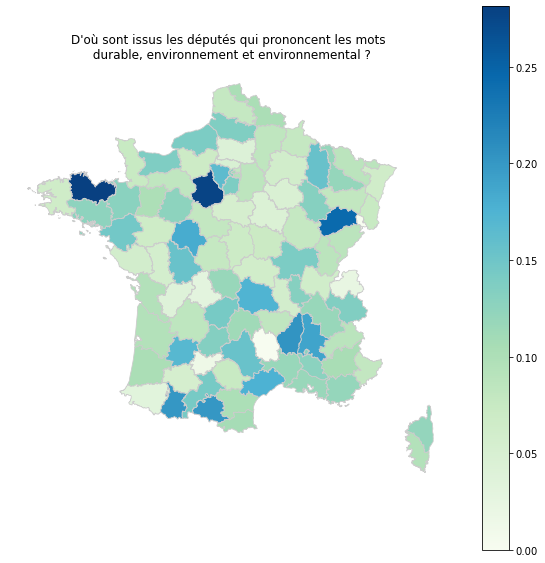

In [32]:
target_words = ['durable','environnement','environnemental']

localisation_mot(target_words)

## Bilan de l'approche descriptive

L'approche descriptive que nous avons mené a exploré plusieurs aspects : 
- l'origine des questions
- la thématique des questions 
- la fréquence d'apparition des mots
- une approche naïve de ségrégation par utilisation de champ lexical

Les conclusions que nous pouvons en tirer sont multiples. 

D'une part, sur l'usage des questions au gouvernement. Il semblerait qu'elles soient un moyen pour les groupes d'opposition d'attirer l'attention du gouvernement sur des problématiques diverses, en particulier sur des problématiques d'intérêt pour les administrés (économie, santé). L'approche géographique indique une forte propension à poser ces questions pour les députés de zones faiblement peuplées. Cela est cohérent avec les thèmes indiqués, qui mobilisent plutôt sur des sujets de politique intérieure. 

L'approche lexicale donne ensuite des indications sur les sujets de prédilection de certains partis. On confirme des résulats attendus, y compris lorsque l'on analyse les résultats géographiquement. 

Le corpus semble donc cohérent avec nos attendus, même si l'on retient une déception dans l'approche fréquentiste, qui semble bruitée notamment par les formalités et tournures de circonstance.